On August 24, 2016, at 3.36am, the center of Italy was hit by a 6.0 magnitude earthquake. There have been 299 deaths, entire villages were destroyed and thousands were left homeless. From that day, tens of thousands of minor earthquakes hit the area with a frequency of about 5 minutes.
The surrounding area has a notorious fame for geological instability, as Italy lies near the fault line that exists between Eurasian and African tectonic plates. Earthquakes happen when one of these plates scrapes, bumps or drags along another plate.
In this notebook we will carry out some basic analysis and visualizations of this dataset. 

A little disclaimer before we begin. I know nearly nothing about earthquakes and geology. I'm just having fun doing some very basic data analysis and visualization, so the things I might say and the thoughts I might have about earthquakes should be taken with a (big) grain of salt.

You can find the full post about this notebook [here][1].


  [1]: http://www.thedataware.com/post/italys-recent-earthquakes-a-look-at-the-data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting

plt.style.use("ggplot")

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

italy_earthquakes_from_2016-08-24_to_2016-11-30.csv



In [2]:
# Read the dataset
df = pd.read_csv('../input/italy_earthquakes_from_2016-08-24_to_2016-11-30.csv').set_index('Time')
df.index = pd.to_datetime(df.index)
df.head()

,Latitude,Longitude,Depth/Km,Magnitude
Time,,,,
2016-08-24 03:36:32.000,42.6983,13.2335,8.1,6.0
2016-08-24 03:37:26.580,42.7123,13.2533,9.0,4.5
2016-08-24 03:40:46.590,42.7647,13.1723,9.7,3.8
2016-08-24 03:41:38.900,42.7803,13.1683,9.7,3.9
2016-08-24 03:42:07.170,42.7798,13.1575,9.7,3.6


In [3]:
# Compute summary statistics
df.describe()

,Latitude,Longitude,Depth/Km,Magnitude
count,8086.000000,8086.000000,8086.000000,8086.000000
mean,42.829557,13.161034,9.968328,2.398368
std,0.125927,0.083058,2.194064,0.426381
min,41.581300,12.537700,0.200000,2.000000
25%,42.751350,13.103200,8.900000,2.100000
50%,42.821800,13.160700,9.900000,2.300000
75%,42.911000,13.215650,10.800000,2.600000
max,43.927300,13.852500,47.900000,6.500000


### Magnitude
The simplest numeric measure of an earthquake strenght is the magnitude.
The magnitude of an earthquake is usually measured by the [Richter Scale][1]. You can check the wikipedia page for more info.

  [1]: https://en.wikipedia.org/wiki/Richter_magnitude_scale

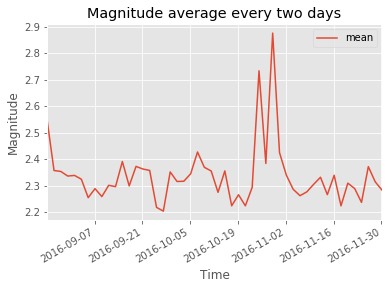

In [4]:
df["Magnitude"].resample("2D").apply([np.mean]).plot()
plt.title("Magnitude average every two days")
plt.ylabel("Magnitude")

From this plot, we can clearly see that there was a spike between October and November. In fact, a 6.5 magnitude earthquake hit on October 30. It also seems like the days preceding that event were characterized by a lower activity. We can see see this better if we average the values over one day, instead that 2 days of the previous plot.

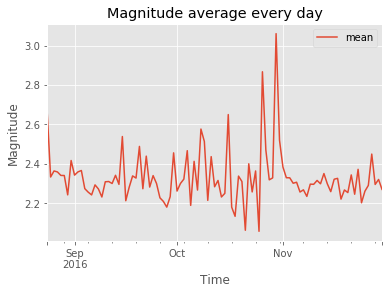

In [5]:
df["Magnitude"].resample("D").apply([np.mean]).plot()
plt.title("Magnitude average every day")
plt.ylabel("Magnitude")

I'm not saying that every earthquake is preceeded by a lower activity in the previous days, it may very well be a coincidence, but it kind of highlights a possible pattern which might deserve future analysis.

### Magnitude Rolling Mean
Another possible way of visualizing the magnitude is the rolling mean, or moving average. Here, instead of taking the mean of each day, we take the mean of a fixed window of n elements. Also, we take only earthquakes with magnitude 3+.

In [6]:
# Pandas series with magnitudes greater than 3.0
magn3 = df.ix[df["Magnitude"] >= 3.0, "Magnitude"]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


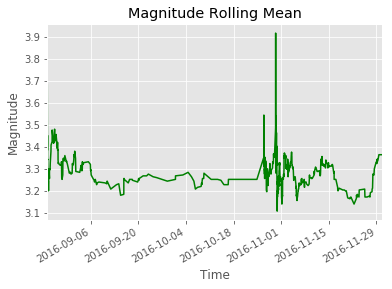

In [7]:
pd.Series.rolling(magn3, window=25).mean().plot(style="-g")
plt.title("Magnitude Rolling Mean")
plt.ylabel("Magnitude")

Besides the same spike as before, we can also see that October had a relatively regular mean, while from November the mean started to fluctuate a bit more. This could mean that the 6.5 earthquake of October 30 may have opened new rifts in the tectonic plate.

### Depth
Let's take a look at the depth now. By plotting a histogram of the different values, we can see a nicely shaped bell curve centered at 10km. We can model this with a gaussian distribution of parameters (mu=10, sigma=2.25) and begin to answer some simple questions like: what is the probability of an earthquake having a depth less than 5km?
Using this rule, this probability is (approximately) 2.3%. Of course, this value is only related to this event, it is not a fact about earthquakes in general.

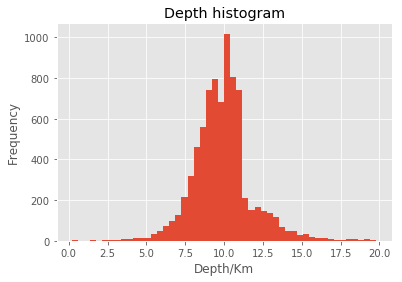

In [8]:
plt.figure()

depth = df[(df["Depth/Km"] < 20) & (df["Depth/Km"] >= 0)]["Depth/Km"]
depth.plot(kind="hist", stacked=True, bins=50)

plt.title("Depth histogram")
plt.xlabel("Depth/Km")

Another interesting question we might try to answer is if earthquakes are more likely to happen at a specific time of day. The 6.0 happened at 3.36am, the 6.5 happened at around 7.50am, so this might be a reasonable thing to search for. Maybe earthquakes are more likely to hit in the morning, or maybe it was just a coincidence. Let's visualize it.

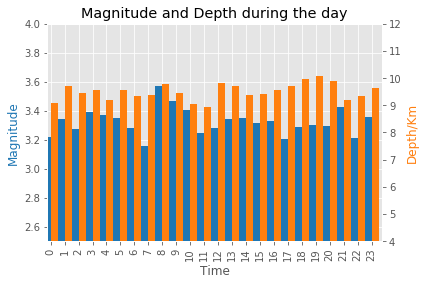

In [9]:
depth_magn = df.where((df["Magnitude"] >= 3.0)).dropna()[["Magnitude", "Depth/Km"]]
dm = depth_magn.groupby(depth_magn.index.hour).mean()

fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_ylim([2.5, 4.0])
ax.set_ylabel("Magnitude")
ax.set_xlabel("Hour of the day")
ax.yaxis.label.set_color("#1f77b4")

ax2 = ax.twinx()
ax2.set_ylim([4.0, 12])
ax2.set_ylabel("Depth/Km")
ax2.set_xlabel("Hour of the day")
ax2.yaxis.label.set_color("#ff7f0e")

width = 0.5

dm["Magnitude"].plot(kind="bar", color='#1f77b4', ax=ax, width=width, position=1)
dm["Depth/Km"].plot(kind="bar", color="#ff7f0e", ax=ax2, width=width, position=0)

plt.grid(False)
plt.title("Magnitude and Depth during the day")

There does not seem to be a significant difference between hours of the day. Thus, in line with the fact the earthquakes are unpredictable, we can conclude that there isn't a particular time of the day in which they are more likely to happen.There does not seem to be a significant difference between hours of the day. Thus, in line with the fact the earthquakes are unpredictable, we can conclude that there isn't a particular time of the day in which they are more likely to happen.

In [10]:
# This function is taken from here:
# https://gist.github.com/tartakynov/83f3cd8f44208a1856ce

def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 10                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = np.fft.fft(x_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

italy_earthquakes_from_2016-08-24_to_2016-11-30.csv



,Latitude,Longitude,Depth/Km,Magnitude
Time,,,,
2016-08-24 03:36:32.000,42.6983,13.2335,8.1,6.0
2016-08-24 03:37:26.580,42.7123,13.2533,9.0,4.5
2016-08-24 03:40:46.590,42.7647,13.1723,9.7,3.8
2016-08-24 03:41:38.900,42.7803,13.1683,9.7,3.9
2016-08-24 03:42:07.170,42.7798,13.1575,9.7,3.6


,Latitude,Longitude,Depth/Km,Magnitude
count,8086.000000,8086.000000,8086.000000,8086.000000
mean,42.829557,13.161034,9.968328,2.398368
std,0.125927,0.083058,2.194064,0.426381
min,41.581300,12.537700,0.200000,2.000000
25%,42.751350,13.103200,8.900000,2.100000
50%,42.821800,13.160700,9.900000,2.300000
75%,42.911000,13.215650,10.800000,2.600000
max,43.927300,13.852500,47.900000,6.500000


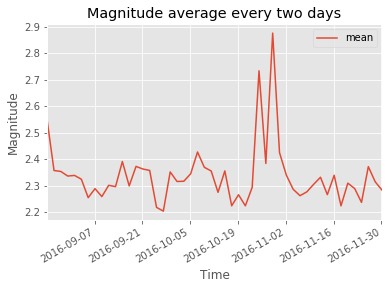

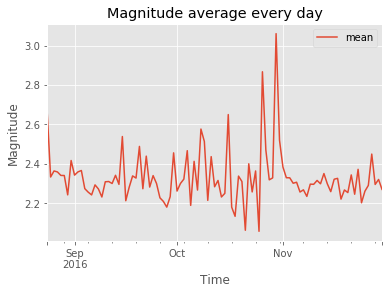

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


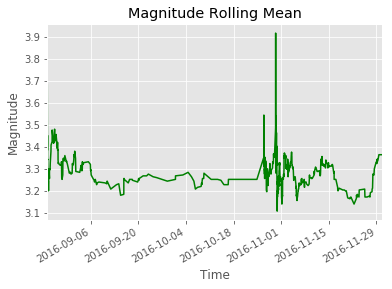

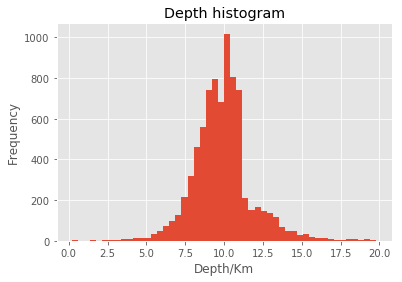

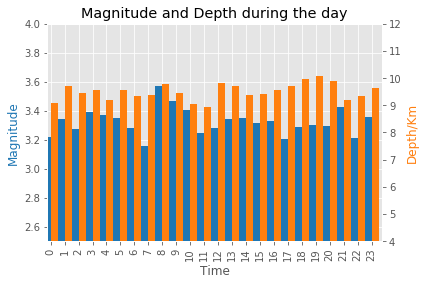

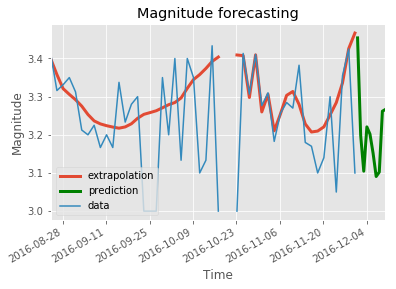

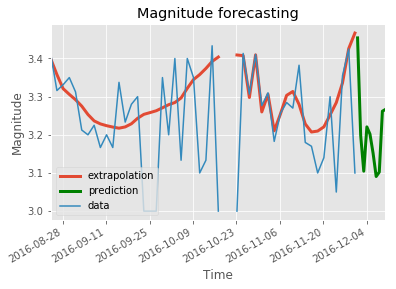

In [11]:
n_predict = 300
resample_period = "2D"
predict_period = "D"

pred = pd.Series(
    fourierExtrapolation(magn3, n_predict),
    index=magn3.index.append(pd.DatetimeIndex(start="2016-12-01", freq="45T", periods=n_predict))
)

fig = plt.figure()

fitted = pred[:-n_predict].resample(resample_period).mean()
predict = pred[-n_predict:].resample(predict_period).mean()

fitted.plot(linewidth=3, label="extrapolation")
predict.plot(linewidth=3, style="-g", label="prediction")
magn3.resample(resample_period).mean().plot(label="data")

plt.title("Magnitude forecasting")
plt.ylabel("Magnitude")
plt.legend(loc="lower left")

Obviously, this forecasting technique was very simple and should not be considered reliable. However, it is an example of the importance of forecasting and time series prediction in general.